<a href="https://colab.research.google.com/github/abhijadhav14/Deep-Learning-CSE5019/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),

            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [4]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [5]:
model = AlexNet(num_classes=10).to(device)
summary(model, (3, 227, 227))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]          34,944
              ReLU-2           [-1, 96, 56, 56]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

In [6]:
print("\nTraining Started...\n")

for epoch in range(1):   # 1 epoch for demo
    running_loss = 0.0

    for i, (images, labels) in enumerate(trainloader): #enumerate is a python written function
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 0:
            print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item():.4f}")

print("\nTraining Finished!")


Training Started...

Epoch 1, Step 0, Loss: 2.2985
Epoch 1, Step 100, Loss: 2.0602
Epoch 1, Step 200, Loss: 1.8056
Epoch 1, Step 300, Loss: 1.9625
Epoch 1, Step 400, Loss: 1.5797
Epoch 1, Step 500, Loss: 1.3402
Epoch 1, Step 600, Loss: 1.5119
Epoch 1, Step 700, Loss: 1.7770
Epoch 1, Step 800, Loss: 1.6750
Epoch 1, Step 900, Loss: 1.5230
Epoch 1, Step 1000, Loss: 1.1258
Epoch 1, Step 1100, Loss: 1.4889
Epoch 1, Step 1200, Loss: 1.1622
Epoch 1, Step 1300, Loss: 1.3332
Epoch 1, Step 1400, Loss: 1.1843
Epoch 1, Step 1500, Loss: 1.3465

Training Finished!


In [7]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%\n")


Test Accuracy: 55.41%



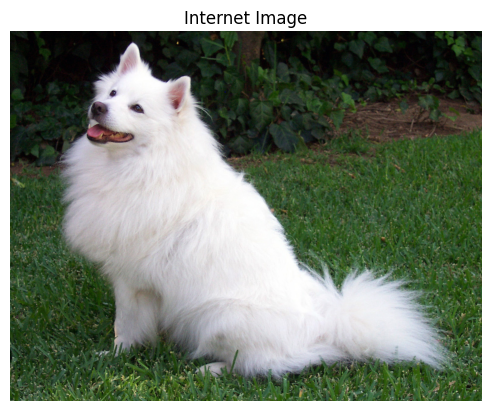


Predicted Class: dog


In [8]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.title("Internet Image")
plt.axis('off')
plt.show()

transform_single = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

img_t = transform_single(img).unsqueeze(0).to(device)

model.eval()
output = model(img_t)
_, predicted = torch.max(output.data, 1)

classes = trainset.classes
print("\nPredicted Class:", classes[predicted.item()])